<center>
  <h1>ST7: Modélisation Des Risques Financiers</h1>
  <h2></h2>
</center>

Le projet est mené par groupe de 4 étudiants entre février et avril 2024. L’objectif est de travailler
sur la gestion des risques ﬁnanciers en faisant intervenir des outils d’optimisation pour construire votre
portefeuille. Vous travaillez sur les mêmes données.

L’objectif du projet est la validation de la capacité à manipuler des données ﬁnancières, mettre en
place une stratégie d’investissement avec des optimisations et analyser la stratégie par rapport au risque,
performance. Il s’agit d’un travail collectif menant à la rédaction d’un rapport et une soutenance devant
un jury.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize

In [2]:
START_DATE = '2015-01-01' 
END_DATE = '2023-12-30'
tickers = ["MSFT", "AAPL", "NVDA", "AMZN", "META", "GOOGL", "GOOG", "LLY", "JPM", "AVGO", "UNH", "TSLA", "V", "XOM", "MA", "JNJ", "PG", "HD", "COST", "ABBV", "AMD", "MRK", "CRM", "CVX", "NFLX", "WMT", "BAC", "ACN", "KO", "LIN", "PEP", "TMO", "ADBE", "WFC", "DIS", "MCD", "ABT", "ORCL", "CSCO", "QCOM", "GE", "INTC", "CAT", "INTU", "IBM", "CMCSA", "VZ", "AMAT", "DHR", "PFE", "TXN", "UBER", "NOW", "UNP", "PM", "AMGN", "COP", "LOW", "ISRG", "SPGI", "HON", "GS", "AXP", "RTX", "NEE", "T", "NKE", "ELV", "PGR", "LRCX", "PLD", "BKNG", "SYK", "ETN", "BLK", "TJX", "MDT", "UPS", "MS", "C", "BMY", "VRTX", "BA", "CB", "CI", "MU", "SBUX", "REGN", "MMC", "DE", "SCHW", "ADP", "CVS", "ADI", "BSX", "MDLZ", "LMT", "KLAC", "AMT", "GILD", "BX", "FI", "PANW", "TMUS", "SNPS", "CDNS", "EQIX", "ZTS", "SHW", "CME", "MO", "WM", "ICE", "TGT", "CMG", "SO", "SLB", "ITW", "CSX", "DUK", "CL", "EOG", "MPC", "MCK", "ANET", "PH", "BDX", "PSX", "PYPL", "TT", "ORLY", "USB", "NOC", "APH", "TDG", "FCX", "AON", "HCA", "EMR", "GD", "PCAR", "NXPI", "MCO", "MAR", "PNC", "FDX"]
# We chose the most represented companies in the S&P 500 index

In [3]:
data = yf.download(tickers[:40], start=START_DATE, end=END_DATE)

[*********************100%***********************]  40 of 40 completed


In [4]:
# Exporting the returns from the data
returns_df = data['Adj Close'].pct_change().fillna(method='ffill')

returns_df = returns_df.fillna(0)
returns_df.index = pd.to_datetime(returns_df.index)

# Computing monthly returns and variance    
monthly_returns_df = returns_df.resample('M').mean()    
monthly_variance_df = returns_df.resample('M').var()

# Computing the covariance matrix for each month
monthly_covariance_matrices = {}

for month, x in returns_df.resample('M'):
    y = x.values.T 
    y = y - np.mean(y, axis=1)[:, np.newaxis]
    monthly_covariance_matrices[month] = 1/(y.shape[1]-1) * np.dot(y, y.T)

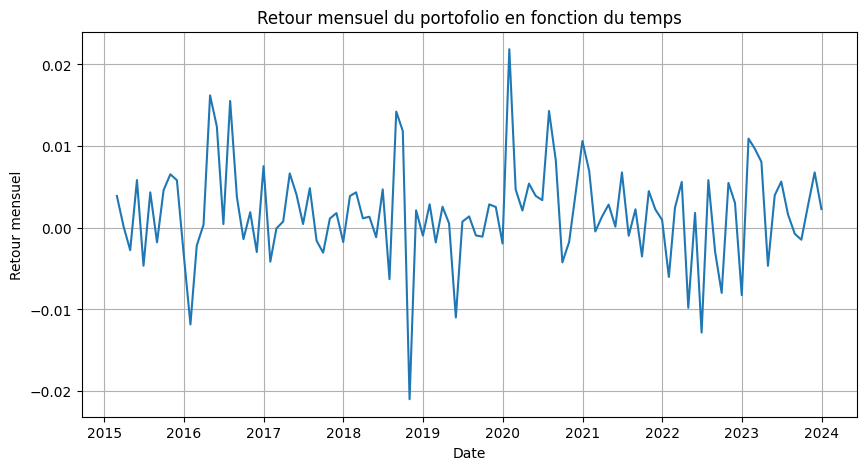

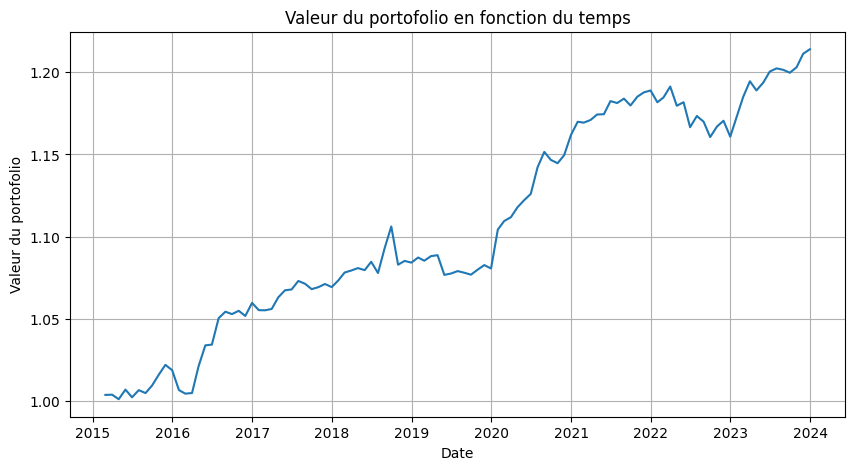

In [5]:
import cvxpy as cp

def markowitz_portfolio_optimization(returns, covariance_matrix):
    # Compute value of vector w that maximizes the expected return
    mu = returns
    Sigma = covariance_matrix

    risk = 0.1
    w = cp.Variable(len(mu))
    objective = cp.Maximize(mu.T @ w)
    constraints = [w.T @ Sigma @ w <= risk, cp.sum(w) == 1, w >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    return w.value

weights_dict = {}

# Applying the Markowitz model to the whole dataset and give the corresponding weights for each month
for date in monthly_returns_df.index:
    weights = markowitz_portfolio_optimization(monthly_returns_df.loc[date].values, monthly_covariance_matrices[date])
    weights_dict[date] = weights

# Plot the mu.T @ w for each month
returns = []
for i in range(1, len(monthly_returns_df.index)):
    returns.append(monthly_returns_df.iloc[i].values @ weights_dict[monthly_returns_df.index[i - 1]])

plt.figure(figsize=(10, 5))
plt.plot(monthly_returns_df.index[1:], returns)
plt.title('Retour mensuel du portofolio en fonction du temps')
plt.xlabel("Date")
plt.ylabel("Retour mensuel")
plt.grid()
plt.show()

# Compute the price of the portfolio using the returns
price = 1
prices = []
for r in returns:
    price = price * (1 + r)
    prices.append(price)

plt.figure(figsize=(10, 5))
plt.plot(monthly_returns_df.index[1:], prices)
plt.title("Valeur du portofolio en fonction du temps")
plt.xlabel("Date")
plt.ylabel("Valeur du portofolio")
plt.grid()
plt.show()